In [1]:
import sys

sys.path.append("/sdf/home/y/youngsam/sw/dune/consistency/cycle_consistency/src")

In [2]:
from models.components.mlp import Mlp

In [3]:
import torch
import matplotlib.pyplot as plt
import yaml
from pfmatch.apps import ToyMC
from pfmatch.utils import load_detector_config
from slar.nets import SirenVis
from sirentv.waveform import BatchedLightSimulation

from tqdm import tqdm

# Load SirenVis model
siren_cfg = """
model:
    network:
        in_features: 3
        hidden_features: 512
        hidden_layers: 5
        out_features: 180
    ckpt_file: "/sdf/home/y/youngsam/sw/dune/consistency/cycle_consistency/data/icarus_2024-11-18.ckpt"
"""
siren_cfg = yaml.safe_load(siren_cfg)
slib = SirenVis(siren_cfg)

# Load ToyMC config
toymc_cfg = """
Detector: icarus_detector

ToyMC:
    TimeAlgo: "random"
    TrackAlgo: "random-extended"
    PeriodTPC: [-1300.,1300]
    PeriodPMT: [-1000., 1000.]
    PEVariation: 0.01
    LightYieldVariation: 0.00
    PosXVariation: 0.0
    TruncateTPC: 0
    NumTracks: 5
    NumpySeed: 1
    NeutrinoTime: 0.

LightPath:
    SegmentSize: 0.1
"""
toymc_cfg = yaml.safe_load(toymc_cfg)
det_cfg = load_detector_config(toymc_cfg)

# Initialize generators
gen = ToyMC(toymc_cfg, det_cfg, slib)
sim = BatchedLightSimulation(cfg="../../sirentv/templates/waveform_sim.yaml").to("cuda:0")
# sim.


def make_photons(qpt_v):
    """Make PMT photo-electron counts from QCluster_t"""
    pe_v = torch.sum(
        slib.visibility(qpt_v[:, :3]) * (qpt_v[:, 3].unsqueeze(-1)), axis=0
    )
    return pe_v


def generate_mock_data(n_events=10):
    """Generate mock photoelectron distributions and waveforms"""
    # Generate ToyMC data
    data = gen.make_flashmatch_inputs(n_events)

    # Get photoelectron distributions
    pe_distributions = []
    for i in range(len(data.qcluster_v)):
        pe_distributions.append(make_photons(data.qcluster_v[i].qpt_v))

    # Convert to waveform inputs (assuming 1ns tick size)
    # We'll place all PEs at a single random time point (delta function)
    n_ticks = 1000  # 3us at 1ns/tick
    waveform_inputs = torch.zeros((n_events, 180, n_ticks), device="cuda:0")

    for i, pe_dist in enumerate(pe_distributions):
        time_point = torch.randint(0, n_ticks, (1,), device="cuda:0").item()
        for ch in range(180):
            n_pe = int(pe_dist[ch].item())
            if n_pe > 0:
                # Place all PEs at a single random time point (delta function)
                waveform_inputs[i, ch, time_point] = n_pe

    # Simulate waveforms
    with torch.no_grad():
        waveforms = sim(waveform_inputs.sum(0), relax_cut=False)

    return pe_distributions, waveform_inputs, waveforms


# Generate and plot example data
pe_distributions, inputs, waveforms = generate_mock_data(n_events=5)
waveforms = waveforms[:, :16_000].reshape(waveforms.shape[0], -1, 16).sum(-1)
waveforms.shape

[Siren] 3 in => 180 out, hidden 512 features 5 layers
        omega 30 first 30.0 hidden, the final layer linear False
[SirenVis] loading model_dict from checkpoint /sdf/home/y/youngsam/sw/dune/consistency/cycle_consistency/data/icarus_2024-11-18.ckpt
[SirenVis] loading model_dict
[SirenVis] loading finished

BatchedLightSimulation Config:
	SINGLET_FRACTION: uniform(0.1, 0.5)
	LIGHT_OSCILLATION_PERIOD: uniform(0.05, 0.20)
	LIGHT_RESPONSE_TIME: uniform(0.01, 0.10)
	LIGHT_GAIN: uniform(-50.0, -20.0)
	TAU_S: uniform(0.0001, 0.01)
	TAU_T: uniform(0.9, 2.1)
	
	NOMINAL_SINGLET_FRACTION: 0.35
	NOMINAL_LIGHT_OSCILLATION_PERIOD: 0.11     # us
	NOMINAL_LIGHT_RESPONSE_TIME: 0.055         # us^-1
	NOMINAL_TAU_S: 0.001                       # us
	NOMINAL_TAU_T: 1.530                       # us
	NOMINAL_LIGHT_GAIN: -45.0                  # ADC us/pe
	
	LIGHT_TICK_SIZE: 0.001
	LIGHT_WINDOW: [1, 10]


/sdf/group/neutrino/youngsam/siren-lartpc/slar/siren_vis.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(f, map_location='cpu')


torch.Size([1, 180, 18998])


torch.Size([180, 1000])

In [ ]:
pe_distributions.shape

In [27]:
wvfm_encoder = Mlp(1000, 512, 192, linear_layer='sine').cuda()

from models.components.transformer import vit_tiny
tformer_encoder = vit_tiny().cuda()
tformer_decoder = vit_tiny().cuda()

In [39]:
import torch
import torch.nn as nn

def make_learned_tokens(shape, init_std=0.02):
    tokens = nn.Parameter(torch.zeros(*shape))
    nn.init.trunc_normal_(tokens, mean=0, std=init_std, a=-init_std, b=init_std)
    return tokens

num_pmts = 180
enc = wvfm_encoder(waveforms)
pos_tokens = make_learned_tokens((num_pmts, tformer_encoder.embed_dim)).cuda()

In [ ]:
enc_out = tformer_encoder(enc.unsqueeze(0), pos_tokens.unsqueeze(0)).last_hidden_state

# flash queries
num_flash_queries = 10
flash_queries = make_learned_tokens(
    (num_flash_queries, tformer_decoder.embed_dim)
).cuda()

# q = flash queries, kv = enc_out
decoder_flash_out = tformer_decoder(
    flash_queries.unsqueeze(0),
    torch.zeros_like(flash_queries),
    kv=enc_out,
    pos_kv=pos_tokens.unsqueeze(0),
)
decoder_flash_out.last_hidden_state.shape

torch.Size([1, 10, 192])

In [86]:
num_pmts = 180
regression_head = Mlp(
    tformer_decoder.embed_dim,
    512,
    num_pmts + 1 + 1,  # PE distribution + time + confidence
).cuda()

final_flashes = regression_head(decoder_flash_out.last_hidden_state)
final_flashes_pe = torch.exp(
    torch.clamp(final_flashes[:, :, :num_pmts], min=-10, max=12)
)
final_flashes_time_log = torch.sigmoid(final_flashes[:, :, num_pmts : num_pmts + 1])
final_flashes_confidence = torch.sigmoid(final_flashes[:, :, num_pmts + 1 :])


final_flashes_pe_weighted = final_flashes_pe * final_flashes_confidence

In [132]:
pe_preds = final_flashes_pe  # Shape: (batch, num_flashes, num_pmts)
time_log_preds = final_flashes_time_log  # Shape: (batch, num_flashes, 1)
confidence_preds = final_flashes_confidence  # Shape: (batch, num_flashes, 1)

# Create a differentiable 2D waveform aggregation
batch_size = pe_preds.shape[0]
num_flashes = pe_preds.shape[1]
num_pmts = 180
num_ticks = 1000

def aggregate_flashes(
    flash_pe_preds, time_log_preds, confidence, num_ticks=1000, sigma=2.0
):
    """
    Differentiable implementation using fully vectorized operations without loops
    Supports batched inputs
    """
    batch_size, num_flashes, num_pmts = flash_pe_preds.shape
    device = flash_pe_preds.device

    # Create time bin centers for all flashes
    time_bins = torch.clamp(
        time_log_preds * num_ticks, min=0, max=num_ticks - 1
    ).squeeze(-1)  # Shape: (batch, num_flashes)

    # Create all time indices and expand to match batch and flash dimensions
    time_indices = torch.arange(num_ticks, device=device)

    # Reshape dimensions for broadcasting:
    # time_bins: (batch, num_flashes, 1)
    # time_indices: (1, 1, num_ticks)
    time_bins_expanded = time_bins.unsqueeze(-1)  # Shape: (batch, num_flashes, 1)
    time_indices_expanded = time_indices.reshape(
        1, 1, num_ticks
    )  # Shape: (1, 1, num_ticks)

    # Compute delta for all batches, flashes and time bins at once
    delta = (
        time_indices_expanded - time_bins_expanded
    )  # Shape: (batch, num_flashes, num_ticks)

    # Compute Gaussian weights for all batches, flashes and time bins
    time_weights = torch.exp(
        -0.5 * (delta / sigma) ** 2
    )  # Shape: (batch, num_flashes, num_ticks)
    time_weights = time_weights / (
        time_weights.sum(dim=2, keepdim=True) + 1e-10
    )  # Normalize along time dimension

    # Scale PE values by confidence
    # flash_pe_preds: (batch, num_flashes, num_pmts)
    # confidence: (batch, num_flashes, 1)
    scaled_pe = flash_pe_preds * confidence.squeeze(-1).unsqueeze(
        -1
    )  # Shape: (batch, num_flashes, num_pmts)

    # Reshape for broadcasting:
    # scaled_pe: (batch, num_flashes, num_pmts, 1)
    # time_weights: (batch, num_flashes, 1, num_ticks)
    scaled_pe_expanded = scaled_pe.unsqueeze(
        -1
    )  # Shape: (batch, num_flashes, num_pmts, 1)
    time_weights_expanded = time_weights.unsqueeze(
        2
    )  # Shape: (batch, num_flashes, 1, num_ticks)

    # Compute contribution for all batches and flashes at once
    contribution = (
        scaled_pe_expanded * time_weights_expanded
    )  # Shape: (batch, num_flashes, num_pmts, num_ticks)

    # Sum contributions across all flashes
    waveform = contribution.sum(dim=1)  # Shape: (batch, num_pmts, num_ticks)

    return waveform


# Generate waveform using vectorized implementation
vectorized_waveform = aggregate_flashes(
    pe_preds, time_log_preds, confidence_preds, num_ticks=1_000, sigma=0.1
)

# Run waveform through waveform simulator
simulated_waveform = sim(vectorized_waveform, relax_cut=False)

simulated_waveform = (
    simulated_waveform[..., :16_000].reshape(batch_size, num_pmts, -1, 16).sum(-1)
)

torch.Size([1, 180, 18998])


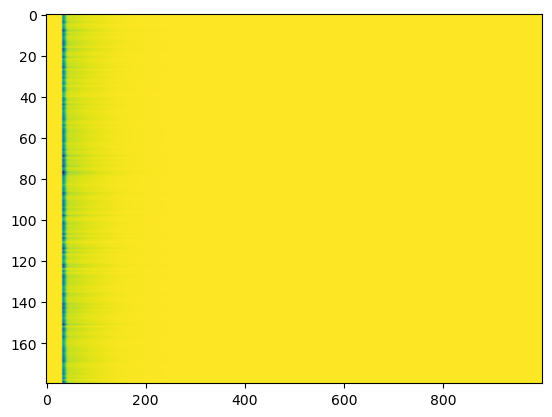

In [139]:
plt.imshow(simulated_waveform.squeeze().detach().cpu().numpy(), aspect='auto')